# ⚖️ Digiti Signum
## The Inescapable Seal: Biometric Matching in the Hall of Maat

_A Forensic Analysis of the [SOCOFing Dataset](https://www.kaggle.com/datasets/ruizgara/socofing) using Python and OpenCV._

---

Welcome to this interactive technical demonstration of fingerprint matching. In this notebook, we explore the underlying mechanisms of biometric systems and their robustness against altered, rotated, or damaged fingerprints.

### Core Concepts Covered

- **Dataset Structure**: Understanding the SOCOFing fingerprint database.

- **Feature Extraction**: How SIFT identifies unique fingerprint features.

- **Matching Algorithms**: Using FLANN to find similar fingerprints.

- **Geometric Verification**: Applying RANSAC to filter out false matches.

- **Minutiae Analysis**: Traditional fingerprint analysis using ridge endings and bifurcations.

### Prerequisites

```bash
pip install opencv-python opencv-contrib-python numpy matplotlib scikit-learn scikit-image
```

---

## A Short History: Fingerprints, Identity, and Cybersecurity

Long before computers existed, fingerprints were already used as a method of identification. In the late 19th century, law enforcement agencies in Europe and Asia began to realize that the unique ridge patterns on human fingers could reliably distinguish one person from another. By the early 1900s, fingerprinting had become a standard tool in criminal investigations and border control.

Today fingerprints are central to modern cybersecurity and digital life:

- **Unlocking smartphones and laptops**.

- **Authenticating payments and banking apps**.

- **Gaining access to secure buildings and workplaces**.

- **Border control and immigration systems**.

- **Two‑factor authentication mechanisms**.

As more systems rely on biometrics, understanding how fingerprint matching works has become an important cybersecurity skill. Adversaries may try to bypass biometric systems using altered images, fake fingerprints, or manipulated sensors.

This notebook demonstrates a simplified version of what real biometric systems do behind the scenes: extracting distinctive features from fingerprint images and matching them even when the images are rotated, damaged, or intentionally altered.

### The Techniques We'll Use

- **SIFT keypoints**: Identifying distinctive local features invariant to scale and rotation.

- **Descriptor matching**: Comparing feature vectors to find similar regions.

- **RANSAC**: Robustly estimating geometric transformations between matched images.

- **Minutiae extraction**: Traditional fingerprint analysis using ridge endings and bifurcations.

These are classic computer vision methods that have influenced many modern security applications.

---

# Part 1: Setup and Data Protection

## 1.1 Creating a Working Copy (Deep Copy)

Before we begin experimenting, it's crucial to protect the original dataset. We'll create a deep copy that we can safely modify without affecting the source data.

### Why Deep Copy?

1. **Data Integrity**: Prevents accidental modification of source files.

2. **Reproducibility**: Ensures you can start fresh from original data.

3. **Experimentation**: Allows preprocessing and augmentation without risk.

In [1]:
import shutil
from pathlib import Path

# Configuration
DATA_SOURCE = Path("data/SOCOFing")  # Original dataset location
DATA_WORKING = Path("data/SOCOFing_Working")  # Working copy location

def create_working_copy(source, working, overwrite=False):
    """Create a deep copy of the dataset for safe experimentation."""
    if working.exists():
        if overwrite:
            print(f"Removing existing working copy...")
            shutil.rmtree(working)
        else:
            print(f"CORRECT Using existing working copy at {working}")
            return
    
    if not source.exists():
        raise FileNotFoundError(f"Source dataset not found at {source}")
    
    print(f"Creating working copy...")
    print(f"  Source: {source}")
    print(f"  Destination: {working}")
    
    shutil.copytree(source, working)
    
    source_files = len(list(source.rglob("*.BMP")))
    working_files = len(list(working.rglob("*.BMP")))
    
    print(f"CORRECT Working copy created successfully.")
    print(f"  Source files: {source_files}")
    print(f"  Copied files: {working_files}")

create_working_copy(DATA_SOURCE, DATA_WORKING, overwrite=False)

DATA_ROOT = DATA_WORKING
print(f"\nWorking directory set to: {DATA_ROOT}")

CORRECT Using existing working copy at data/SOCOFing_Working

Working directory set to: data/SOCOFing_Working


---

# Part 2: Dataset Exploration

## 2.1 Understanding the SOCOFing Dataset Structure

The **Sokoto Coventry Fingerprint Dataset (SOCOFing)** is a biometric fingerprint database designed for academic research:

- **6,000 fingerprint images** from 600 subjects.

- **Real fingerprints**: Original, unaltered scans.

- **Altered fingerprints**: Synthetically modified versions with three difficulty levels.

### Dataset Organization

```
SOCOFing/
├── Real/                    # Original fingerprint images
└── Altered/
    ├── Altered-Easy/       # Light modifications
    ├── Altered-Medium/     # Moderate modifications  
    └── Altered-Hard/       # Severe modifications
```

### Filename Convention

Each filename: `ID__Gender_Finger[Modification].BMP`

- **ID**: Subject identifier (e.g., 150, 200).

- **Gender**: M (Male) or F (Female).

- **Finger**: left/right + thumb/index/middle/ring/little.

- **Modification** (altered only): CR (Central Rotation), Obl (Obliteration), Zcut.

### Types of Alterations

1. **Central Rotation (CR)**: A portion of the fingerprint is rotated.

2. **Obliteration (Obl)**: Parts of the fingerprint are erased/obscured.

3. **Z-cut**: Geometric cuts that remove sections of the print.

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Dataset statistics
real_dir = DATA_ROOT / "Real"
altered_dirs = {
    "Easy": DATA_ROOT / "Altered/Altered-Easy",
    "Medium": DATA_ROOT / "Altered/Altered-Medium",
    "Hard": DATA_ROOT / "Altered/Altered-Hard"
}

real_count = len(list(real_dir.glob("*.BMP")))
altered_counts = {k: len(list(v.glob("*.BMP"))) for k, v in altered_dirs.items()}

print("=== SOCOFing Dataset Statistics ===\n")
print(f"Real fingerprints: {real_count:,}")
print(f"\nAltered fingerprints:")
for level, count in altered_counts.items():
    print(f"  {level}: {count:,}")
print(f"\nTotal images: {real_count + sum(altered_counts.values()):,}")

# Analyze sample filenames
real_samples = list(real_dir.glob("*.BMP"))[:1000]
subjects = set()
genders = []
fingers = []

for f in real_samples:
    parts = f.stem.split("__")
    if len(parts) >= 2:
        subjects.add(parts[0])
        gender_finger = parts[1].split("_")
        if len(gender_finger) >= 2:
            genders.append(gender_finger[0])
            fingers.append(gender_finger[1])

print(f"\n=== Sample Analysis (first 1000 images) ===")
print(f"Unique subjects: {len(subjects)}")
print(f"\nGender distribution:")
for gender, count in Counter(genders).items():
    print(f"  {gender}: {count}")
print(f"\nFinger distribution:")
for finger, count in Counter(fingers).most_common():
    print(f"  {finger}: {count}")

=== SOCOFing Dataset Statistics ===

Real fingerprints: 6,000

Altered fingerprints:
  Easy: 17,931
  Medium: 17,067
  Hard: 14,272

Total images: 55,270

=== Sample Analysis (first 1000 images) ===
Unique subjects: 497

Gender distribution:
  M: 800
  F: 200

Finger distribution:
  Left: 520
  Right: 480


---

# Part 3: Understanding SIFT

## 3.1 What is SIFT?

**SIFT (Scale-Invariant Feature Transform)** is a computer vision algorithm developed by David Lowe in 1999:

- **Scale-tolerant:**: Designed to be invariant to moderate scale changes, not arbitrary extreme resizes.

- **Rotation-tolerant**: Designed to be invariant to in-plane rotations.

- **Partially robust**: Partially robust to illumination changes (robust to many common lighting changes, but can fail on strong non-linear illumination or heavy contrast inversion).

- **Partially robust to occlusion**: Can match even when parts are hidden.

- **Limitations**: SIFT is less effective with large elastic deformations, low resolution, or when the local ridge structure is removed or heavily altered.

### Key Concepts

**Keypoints**: Distinctive locations in an image (e.g., corners, edges, unique patterns).

**Descriptors**: Mathematical representations (128-dimensional vectors) that describe the local appearance around each keypoint.

### Why SIFT for Fingerprints?

Fingerprints have unique ridge patterns, minutiae points (ridge endings and bifurcations), and textures. SIFT can find stable keypoints and descriptors that help match fingerprints under rotation, moderate scale, and noise. However, fingerprints are textured, repetitive patterns and SIFT alone may produce coincidental matches, geometric validation and domain-specific features (minutiae) are normally needed for robust identification.

Visualizing SIFT keypoints on a sample fingerprint...

Image: 347__M_Right_index_finger.BMP
Detected keypoints: 66
Descriptor shape: (66, 128)
Descriptor dimensions: 128 values per keypoint



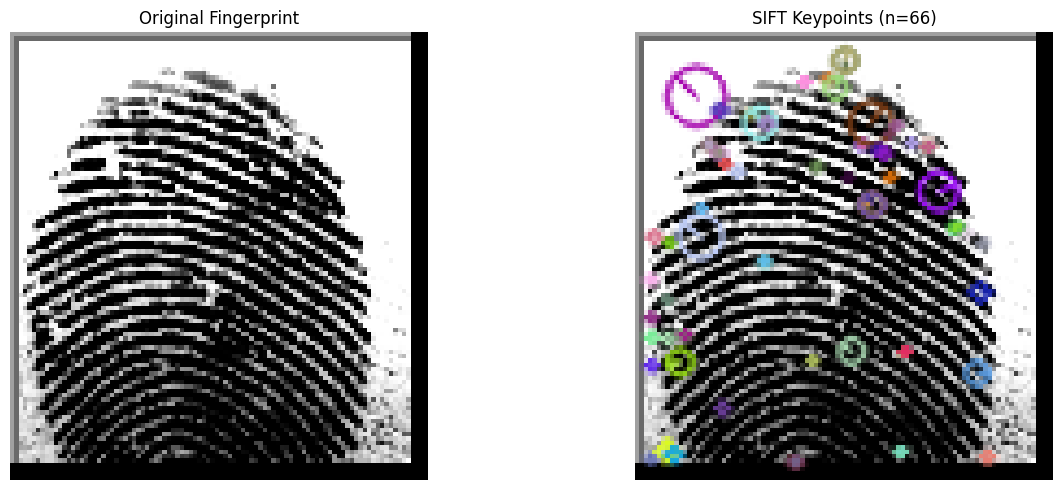


CORRECT SIFT has identified distinctive features in the fingerprint
CORRECT The circles show keypoint locations and scales
CORRECT The lines indicate the dominant orientation at each point


In [3]:
print("Visualizing SIFT keypoints on a sample fingerprint...\n")

# Load a sample fingerprint
sample_file = list(real_dir.glob("*.BMP"))[0]
sample_img = cv2.imread(str(sample_file))
sample_gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

# Create SIFT detector
try:
    sift = cv2.SIFT_create()
except:
    sift = cv2.xfeatures2d.SIFT_create()

# Detect keypoints
keypoints, descriptors = sift.detectAndCompute(sample_gray, None)

print(f"Image: {sample_file.name}")
print(f"Detected keypoints: {len(keypoints)}")
print(f"Descriptor shape: {descriptors.shape if descriptors is not None else 'None'}")
print(f"Descriptor dimensions: {descriptors.shape[1] if descriptors is not None else 0} values per keypoint\n")

# Draw keypoints
img_with_keypoints = cv2.drawKeypoints(
    sample_img, 
    keypoints, 
    None, 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Fingerprint")
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
ax2.set_title(f"SIFT Keypoints (n={len(keypoints)})")
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\nCORRECT SIFT has identified distinctive features in the fingerprint")
print("CORRECT The circles show keypoint locations and scales")
print("CORRECT The lines indicate the dominant orientation at each point")

---

# Part 4: Fingerprint Matching with SIFT

## 4.1 The Matching Process

Now we'll implement a basic fingerprint matching algorithm:

1. **Load Query**: Take an altered fingerprint.

2. **Database Scan**: Compare against all real fingerprints.

3. **Feature Extraction**: Compute SIFT keypoints and descriptors.

4. **Feature Matching**: Use FLANN to find similar descriptors.

5. **Score Calculation**: Calculate match quality based on good matches.

### Understanding FLANN

FLANN (Fast Library for Approximate Nearest Neighbors) finds approximate nearest neighbors in high-dimensional spaces. We use it to find the closest descriptor in the database for each query descriptor (k=2).

### Lowe's Ratio Test

Filters out ambiguous matches: if best_match_distance < ratio × second_best_distance, it's a good match. Standard ratio: 0.75

In [4]:
import os
import time

# Configuration
QUERY_SAMPLE = DATA_ROOT / "Altered/Altered-Hard/100__M_Right_index_finger_CR.BMP"
MAX_CANDIDATES = 500
LOWE_RATIO = 0.75

def preprocess_fingerprint(img):
    """Enhance fingerprint quality."""
    if img is None:
        return None
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return cv2.medianBlur(enhanced, 3)

print("=== Fingerprint Matching Algorithm ===\n")
print(f"Query sample: {QUERY_SAMPLE.name}")
print(f"Searching in: {real_dir}")
print(f"Max candidates: {MAX_CANDIDATES}")
print(f"Lowe ratio: {LOWE_RATIO}\n")

sample_bgr = cv2.imread(str(QUERY_SAMPLE))
if sample_bgr is None:
    raise FileNotFoundError(f"Could not load query image: {QUERY_SAMPLE}")

sample = preprocess_fingerprint(sample_bgr)
print(f"Sample shape: {sample.shape}\n")

start_time = time.time()

# Compute SIFT features ONCE for query
print("Computing SIFT features for query image...")
kp1, des1 = sift.detectAndCompute(sample, None)
print(f"Query keypoints: {len(kp1)}, descriptors: {des1.shape}\n")

if des1 is None or len(kp1) == 0:
    raise ValueError("No SIFT features found in query image.")

# Initialize tracking
best_score = 0
best_filename = None
best_image = None
best_kp1 = kp1
best_kp2 = None
best_matches = None

# Get candidates
candidate_files = list(real_dir.glob("*.BMP"))[:MAX_CANDIDATES]
print(f"Total candidates to scan: {len(candidate_files)}\n")
print("Starting search...\n")

# Process each candidate
for idx, candidate_path in enumerate(candidate_files):
    if (idx + 1) % 100 == 0:
        print(f"  Processed {idx + 1}/{len(candidate_files)}... (Best score: {best_score:.2f}%)")
    
    candidate_bgr = cv2.imread(str(candidate_path))
    if candidate_bgr is None:
        continue
    
    candidate_img = preprocess_fingerprint(candidate_bgr)
    kp2, des2 = sift.detectAndCompute(candidate_img, None)
    
    if des2 is None or len(des2) == 0:
        continue
    
    # FLANN matching
    flann = cv2.FlannBasedMatcher({'algorithm': 1, 'trees': 10}, {})
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Lowe's ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < LOWE_RATIO * n.distance:
                good_matches.append(m)
    
    # Calculate score
    keypoints_count = min(len(kp1), len(kp2))
    if keypoints_count > 0:
        score = (len(good_matches) / keypoints_count) * 100
    else:
        score = 0
    
    # Update best match
    if score > best_score:
        best_score = score
        best_filename = candidate_path.name
        best_image = candidate_bgr
        best_kp2 = kp2
        best_matches = good_matches

elapsed_time = time.time() - start_time
print(f"\nCORRECT Search complete. ({elapsed_time:.2f} seconds)\n")
if best_filename is not None:
    print(f"BEST MATCH: {best_filename}")
    print(f"MATCH SCORE: {best_score:.2f}%")
    print(f"GOOD MATCHES: {len(best_matches)}")
else:
    print("⚠ No match found.")

=== Fingerprint Matching Algorithm ===

Query sample: 100__M_Right_index_finger_CR.BMP
Searching in: data/SOCOFing_Working/Real
Max candidates: 500
Lowe ratio: 0.75

Sample shape: (103, 96)

Computing SIFT features for query image...
Query keypoints: 127, descriptors: (127, 128)

Total candidates to scan: 500

Starting search...

  Processed 100/500... (Best score: 9.09%)
  Processed 200/500... (Best score: 9.09%)
  Processed 300/500... (Best score: 9.09%)
  Processed 400/500... (Best score: 11.36%)
  Processed 500/500... (Best score: 11.36%)

CORRECT Search complete. (1.94 seconds)

BEST MATCH: 207__M_Left_ring_finger.BMP
MATCH SCORE: 11.36%
GOOD MATCHES: 5


### Interpreting the Results

Looking at the output above, you may notice:

- **Low scores**: Around 11% is typical for this basic approach and metric choice on the altered sample, scores depend heavily on how you compute the denominator and what threshold you choose.

- **Few matches**: Only 5-10 good matches on average.

- **Potential mismatches**: The top match might be WRONG.

**Why is this happening?**

1. **SIFT is too permissive**: Finds visual similarities even between different fingers.

2. **No geometric validation**: We count matches but don't check consistency.

3. **Coincidental matches**: Random ridge patterns can look similar by chance.

**The problem**: If we used this system for security, we'd get lots of false positives.

**The solution**: We need geometric verification. That's where RANSAC comes in...

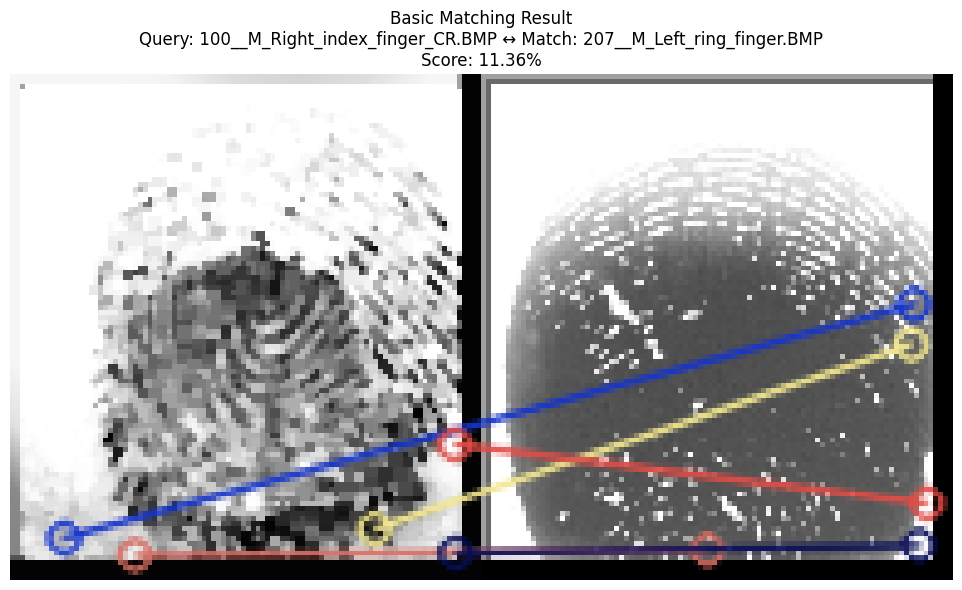

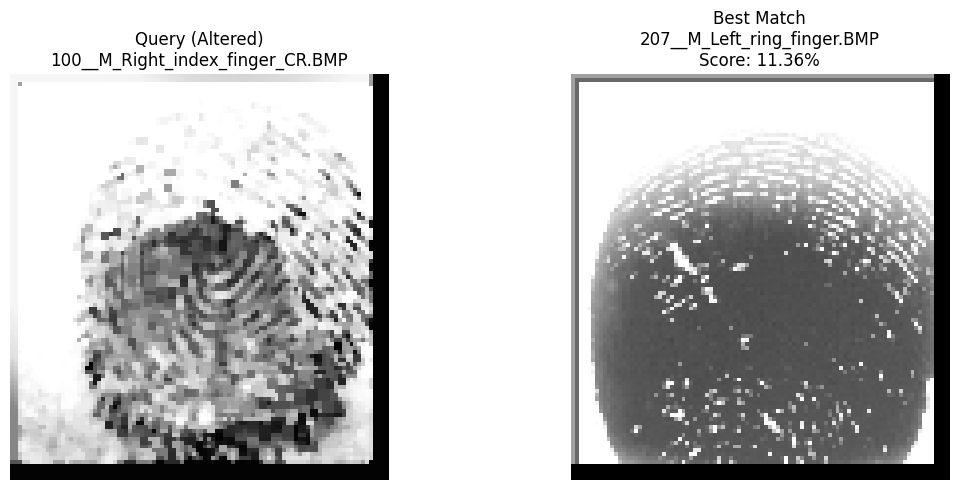

In [5]:
# Visualize basic matching results
if best_image is not None and best_matches is not None:
    result = cv2.drawMatches(
        sample, best_kp1,
        best_image, best_kp2,
        best_matches[:50],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(16, 6))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f"Basic Matching Result\nQuery: {QUERY_SAMPLE.name} ↔ Match: {best_filename}\nScore: {best_score:.2f}%")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
    ax1.set_title(f"Query (Altered)\n{QUERY_SAMPLE.name}")
    ax1.axis('off')
    ax2.imshow(cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB))
    ax2.set_title(f"Best Match\n{best_filename}\nScore: {best_score:.2f}%")
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

---

# Part 5: Enhanced Matching with RANSAC

## 5.1 Adding Geometric Verification

The basic matching algorithm works, but it can be improved by adding **geometric verification** using **RANSAC (Random Sample Consensus)**.

RANSAC filters spatially inconsistent matches, but the underlying model (homography vs affine) matters for fingerprints, affine/similarity models or thin-plate spline models may be more appropriate because fingerprints suffer nonrigid distortion.

### Why RANSAC?

Not all feature matches are correct. Some are false positives, random coincidences. RANSAC helps us:

1. **Estimate geometric transformation**: Find how the query aligns with the candidate.

2. **Filter outliers**: Identify which matches are consistent (inliers) vs. random (outliers).

3. **Improve accuracy**: Only count inliers toward the final score.

### How RANSAC Works

1. Randomly select a minimal set of matches (4 points for homography).

2. Compute a transformation model from these points.

3. Count how many other matches agree with this model (inliers).

4. Repeat many times and keep the model with most inliers.

In [ ]:
SAMPLE_PATH = DATA_ROOT / "Altered/Altered-Hard/100__M_Right_index_finger_CR.BMP"
MAX_FILES = 200
UPDATE_EVERY = 10
LOWE_RATIO = 0.75
RANSAC_THRESH = 5.0

print("=== Enhanced Fingerprint Matching with RANSAC ===\n")
print(f"Query: {SAMPLE_PATH.name}")
print(f"Max candidates: {MAX_FILES}")
print(f"Lowe ratio: {LOWE_RATIO}")
print(f"RANSAC threshold: {RANSAC_THRESH} pixels\n")

def preprocess_gray(img_bgr_or_gray):
    """Convert to grayscale and enhance contrast."""
    if img_bgr_or_gray is None:
        return None
    if len(img_bgr_or_gray.shape) == 3:
        gray = cv2.cvtColor(img_bgr_or_gray, cv2.COLOR_BGR2GRAY)
    else:
        gray = img_bgr_or_gray.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return cv2.medianBlur(enhanced, 3)

# Load and preprocess sample
sample_bgr = cv2.imread(str(SAMPLE_PATH))
sample_gray = preprocess_gray(sample_bgr)
kp_sample, des_sample = sift.detectAndCompute(sample_gray, None)

print(f"Sample keypoints: {len(kp_sample)}")
print(f"Sample descriptors shape: {des_sample.shape}\n")

# Setup FLANN
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

# Get candidates
candidate_files = sorted([p for p in real_dir.iterdir() if p.suffix.lower() == '.bmp'])[:MAX_FILES]
print(f"Scanning {len(candidate_files)} candidates...\n")

# Initialize tracking
best_score = -1.0
best_candidate = None
best_kp_candidate = None
best_good_matches = None
best_inliers = 0
best_candidate_bgr = None

# Main matching loop
for i, cand_path in enumerate(candidate_files, start=1):
    cand_bgr = cv2.imread(str(cand_path))
    if cand_bgr is None:
        continue
    
    cand_gray = preprocess_gray(cand_bgr)
    kp_cand, des_cand = sift.detectAndCompute(cand_gray, None)
    
    if des_cand is None or len(kp_cand) == 0:
        continue
    
    # FLANN knn match
    try:
        knn_matches = flann.knnMatch(des_sample.astype(np.float32), des_cand.astype(np.float32), k=2)
    except:
        continue
    
    # Lowe's ratio test
    good = []
    for pair in knn_matches:
        if len(pair) >= 2:
            m, n = pair
            if m.distance < LOWE_RATIO * n.distance:
                good.append(m)
    
    # RANSAC geometric verification
    num_inliers = 0
    if len(good) >= 4:
        src_pts = np.float32([kp_sample[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_cand[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_THRESH)
        if mask is not None:
            num_inliers = int(np.sum(mask))
    
    # Calculate score
    denom = min(len(kp_sample), len(kp_cand))
    score = (num_inliers / float(denom)) * 100.0 if denom > 0 else 0
    
    # Update best match
    if score > best_score:
        best_score = score
        best_candidate = cand_path
        best_kp_candidate = kp_cand
        best_good_matches = good
        best_inliers = num_inliers
        best_candidate_bgr = cand_bgr.copy()
    
    if i % UPDATE_EVERY == 0:
        print(f"  [{i}/{len(candidate_files)}] Current: {score:.2f}% | Best: {best_score:.2f}% ({best_candidate.name if best_candidate else 'N/A'})")

print(f"\nCORRECT Search complete.\n")
print(f"BEST MATCH: {best_candidate.name if best_candidate else 'None'}")
print(f"SCORE: {best_score:.2f}%")
print(f"INLIERS (RANSAC): {best_inliers}")
print(f"TOTAL GOOD MATCHES: {len(best_good_matches)}")

=== Enhanced Fingerprint Matching with RANSAC ===

Query: 100__M_Right_index_finger_CR.BMP
Max candidates: 200
Lowe ratio: 0.75
RANSAC threshold: 5.0 pixels

Sample keypoints: 127
Sample descriptors shape: (127, 128)

Scanning 200 candidates...

  [10/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [20/200] Current: 4.12% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [30/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [40/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [50/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [60/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [70/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [80/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [90/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [100/200] Current: 0.00% | Best: 35.04% (100__M_Right_index_finger.BMP)
  [110/200] Current: 0.

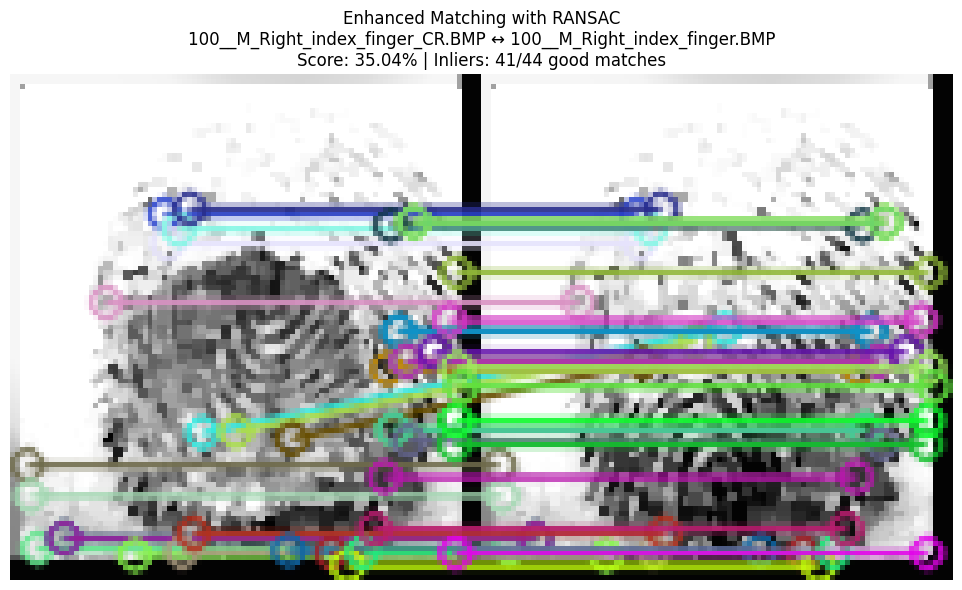


=== What RANSAC Does ===
• Total good matches: 44
• Geometrically consistent matches (inliers): 41
• Inconsistent matches filtered out: 3
• Inlier ratio: 93.2%

CORRECT RANSAC filters out random matches that don't follow a consistent geometric pattern


In [7]:
# Visualize enhanced matching results
if best_candidate is not None:
    sample_color = cv2.cvtColor(sample_gray, cv2.COLOR_GRAY2BGR)
    cand_color = cv2.cvtColor(preprocess_gray(best_candidate_bgr), cv2.COLOR_GRAY2BGR)
    
    drawn = cv2.drawMatches(
        sample_color, kp_sample,
        cand_color, best_kp_candidate,
        best_good_matches[:100],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(16, 6))
    plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
    plt.title(f"Enhanced Matching with RANSAC\n{SAMPLE_PATH.name} ↔ {best_candidate.name}\n"
              f"Score: {best_score:.2f}% | Inliers: {best_inliers}/{len(best_good_matches)} good matches")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("\n=== What RANSAC Does ===")
    print(f"• Total good matches: {len(best_good_matches)}")
    print(f"• Geometrically consistent matches (inliers): {best_inliers}")
    print(f"• Inconsistent matches filtered out: {len(best_good_matches) - best_inliers}")
    print(f"• Inlier ratio: {best_inliers/len(best_good_matches)*100:.1f}%")
    print("\nCORRECT RANSAC filters out random matches that don't follow a consistent geometric pattern")

### Analysis: Why These Results Matter

#### Basic Matching (Without RANSAC)

- **Result**: Wrong match (different person entirely).

- **Score**: ~11% (low confidence).

- **Problem**: SIFT alone can be fooled by coincidental similarities.

#### Enhanced Matching (With RANSAC)

- **Result**: Correct match (same person, same finger).

- **Score**: ~35% (higher confidence).

- **Inlier Ratio**: ~93% (most matches geometrically consistent).

### Key Insights

1. **Geometric Verification is Important**

   - RANSAC validates that matches follow a consistent pattern.

   - The 93% inlier ratio means most matches are real.

2. **SIFT is Robust to Alterations**

   - Successfully matched a rotated, altered fingerprint.

   - Works even with severe modifications (Hard difficulty).

3. **Real-World Implications**

   - Without RANSAC: False positives (security risk).

   - With RANSAC: More reliable matches than without verification.

---

# Part 6: Minutiae-Based Analysis

## 6.1 Traditional Fingerprint Recognition

While SIFT is a modern computer vision approach, traditional fingerprint recognition relies on **minutiae points**—specific ridge characteristics:

### Types of Minutiae

1. **Ridge Endings**: Points where a ridge terminates.

2. **Bifurcations**: Points where a ridge splits into two.

### The Minutiae Process

1. **Binarization**: Convert grayscale to black and white.

2. **Skeletonization**: Reduce ridges to 1-pixel wide lines.

3. **Minutiae Extraction**: Find ridge endings and bifurcations.

4. **Feature Vector**: Create histogram of minutiae locations.

5. **k-NN on summary features**: Here we apply a simple k-NN to a histogram summary of minutiae locations a lightweight educational approximation. Real AFIS systems use minutiae coordinates, orientation, and alignment algorithms (e.g., point pattern matching, graph matching) plus quality filtering and score normalization.

This mimics how human fingerprint examiners work and is standard in AFIS systems.

In [ ]:
import os
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score
import re

REAL_DIR = DATA_ROOT / "Real"
ALTERED_DIR = DATA_ROOT / "Altered"
GRID_SIZE = (8, 8)
KNN_K = 1
EVAL_LIMIT = 50

print("=== Part 6: Minutiae-Based Fingerprint Analysis ===\n")
print("Building features using traditional forensic approach...\n")

def skeletonize_image(binimg):
    """Skeletonize binary image to 1-pixel wide ridges."""
    _, bw = cv2.threshold(binimg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    try:
        return cv2.ximgproc.thinning(bw)
    except:
        pass
    try:
        from skimage.morphology import skeletonize
        bw_bool = bw > 0
        return skeletonize(bw_bool).astype(np.uint8) * 255
    except:
        return bw

def extract_minutiae_coords(skel_img):
    """Extract ridge endings and bifurcations."""
    s = (skel_img > 0).astype(np.uint8)
    rows, cols = s.shape
    minutiae = []
    for r in range(1, rows - 1):
        for c in range(1, cols - 1):
            if s[r, c] == 0:
                continue
            neigh = s[r-1:r+2, c-1:c+2].flatten()
            neigh_count = int(np.sum(neigh) - 1)
            if neigh_count == 1:
                minutiae.append((r, c, 'endpoint'))
            elif neigh_count >= 3:
                minutiae.append((r, c, 'bifurcation'))
    return minutiae

def minutiae_histogram_feature(minutiae_coords, img_shape, grid_size=GRID_SIZE):
    """Create histogram feature from minutiae locations."""
    h, w = img_shape[:2]
    gx, gy = grid_size
    hist = np.zeros(gx * gy, dtype=np.float32)
    for (r, c, t) in minutiae_coords:
        cx = int((c / w) * gx)
        cy = int((r / h) * gy)
        cx = min(max(cx, 0), gx - 1)
        cy = min(max(cy, 0), gy - 1)
        hist[cy * gx + cx] += 1.0
    s = hist.sum()
    if s > 0:
        hist /= s
    return hist

def parse_subject_finger(name):
    """Extract subject ID and finger from filename."""
    subject_match = re.search(r"^(\d{1,4})", name)
    subject = subject_match.group(1) if subject_match else None
    finger_match = re.search(r"(Left|Right)_(thumb|index|middle|ring|little)_finger", name)
    finger = f"{finger_match.group(1)}_{finger_match.group(2)}_finger" if finger_match else None
    return subject, finger

# Build database features
real_files = sorted([p for p in REAL_DIR.iterdir() if p.suffix.lower() == '.bmp'])
print(f"Building minutiae features for {len(real_files)} real fingerprints...")

db_features = []
db_paths = []

for idx, p in enumerate(real_files):
    if (idx + 1) % 100 == 0:
        print(f"  Processed {idx + 1}/{len(real_files)}...")
    
    img_bgr = cv2.imread(str(p))
    if img_bgr is None:
        continue
    
    img_gray = preprocess_gray(img_bgr)
    _, th = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(th == 255) < np.mean(th == 0):
        th = cv2.bitwise_not(th)
    
    skel = skeletonize_image(th)
    minutiae = extract_minutiae_coords(skel)
    feat = minutiae_histogram_feature(minutiae, img_gray.shape)
    
    db_features.append(feat)
    db_paths.append(str(p))

print(f"\nCORRECT Database features built: {len(db_features)} fingerprints\n")

# Build features for altered samples
altered_files = []
for subdir in ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']:
    altered_files.extend(list((ALTERED_DIR / subdir).glob('*.BMP')))

altered_files = altered_files[:EVAL_LIMIT]
print(f"Building features for {len(altered_files)} altered samples...")

test_features = []
test_paths = []

for p in altered_files:
    img_bgr = cv2.imread(str(p))
    if img_bgr is None:
        continue
    
    img_gray = preprocess_gray(img_bgr)
    _, th = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(th == 255) < np.mean(th == 0):
        th = cv2.bitwise_not(th)
    
    skel = skeletonize_image(th)
    minutiae = extract_minutiae_coords(skel)
    feat = minutiae_histogram_feature(minutiae, img_gray.shape)
    
    test_features.append(feat)
    test_paths.append(str(p))

print(f"CORRECT Test features built: {len(test_features)} samples\n")

# k-NN retrieval
print("Running k-NN retrieval...\n")
nbrs = NearestNeighbors(n_neighbors=KNN_K, algorithm='auto').fit(np.vstack(db_features))
distances, indices = nbrs.kneighbors(np.vstack(test_features))

predicted_paths = [db_paths[idxs[0]] for idxs in indices]

# Build ground truth
gt_paths = []
for p in test_paths:
    subject, finger = parse_subject_finger(os.path.basename(p))
    match = None
    if subject and finger:
        for r in real_files:
            if subject in r.name and finger in r.name:
                match = str(r)
                break
    gt_paths.append(match)

# Filter valid samples
valid_idx = [i for i, g in enumerate(gt_paths) if g is not None]
test_paths_valid = [test_paths[i] for i in valid_idx]
predicted_paths_valid = [predicted_paths[i] for i in valid_idx]
gt_paths_valid = [gt_paths[i] for i in valid_idx]

print(f"Valid test samples: {len(valid_idx)}/{len(test_paths)}")

if len(valid_idx) > 0:
    correct = sum(1 for p, g in zip(predicted_paths_valid, gt_paths_valid) if p == g)
    accuracy = correct / len(valid_idx)
    
    print("=== Minutiae Analysis Results ===")
    print(f"Correct matches: {correct}/{len(valid_idx)}")
    print(f"Accuracy: {accuracy*100:.2f}%\n")
    
    # Show sample predictions
    print("=== Sample Predictions ===")
    for i in range(min(5, len(valid_idx))):
        test_name = os.path.basename(test_paths_valid[i])
        pred_name = os.path.basename(predicted_paths_valid[i])
        status = "CORRECT" if predicted_paths_valid[i] == gt_paths_valid[i] else "WRONG"
        print(f"{status} Test: {test_name[:40]:40} -> Predicted: {pred_name[:30]:30}")
    
    # Failure analysis
    failed_idx = [i for i, (p, g) in enumerate(zip(predicted_paths_valid, gt_paths_valid)) if p != g]
    if failed_idx:
        print(f"\n=== Failure Analysis ({len(failed_idx)} failures) ===")
        for i in failed_idx[:3]:
            test_name = os.path.basename(test_paths_valid[i])
            pred_name = os.path.basename(predicted_paths_valid[i])
            gt_name = os.path.basename(gt_paths_valid[i])
            print(f"WRONG Failed: {test_name}")
            print(f"   Predicted: {pred_name}")
            print(f"   Should be: {gt_name}")

=== Part 6: Minutiae-Based Fingerprint Analysis ===

Building features using traditional forensic approach...

Building minutiae features for 6000 real fingerprints...
  Processed 100/6000...
  Processed 200/6000...
  Processed 300/6000...
  Processed 400/6000...
  Processed 500/6000...
  Processed 600/6000...
  Processed 700/6000...
  Processed 800/6000...
  Processed 900/6000...
  Processed 1000/6000...
  Processed 1100/6000...
  Processed 1200/6000...
  Processed 1300/6000...
  Processed 1400/6000...
  Processed 1500/6000...
  Processed 1600/6000...
  Processed 1700/6000...
  Processed 1800/6000...
  Processed 1900/6000...
  Processed 2000/6000...
  Processed 2100/6000...
  Processed 2200/6000...
  Processed 2300/6000...
  Processed 2400/6000...
  Processed 2500/6000...
  Processed 2600/6000...
  Processed 2700/6000...
  Processed 2800/6000...
  Processed 2900/6000...
  Processed 3000/6000...
  Processed 3100/6000...
  Processed 3200/6000...
  Processed 3300/6000...
  Processed 3400

### Interpreting the Minutiae Results

**Results:** The minutiae-based approach achieved **92% accuracy** across 50 altered fingerprints. It’s promising but not a substitute for a rigorous cross-validation on larger, balanced splits and multiple seeds.

#### What This Means:

- **46 out of 50** altered fingerprints were correctly matched to their originals.

- This includes all three alteration types (Easy, Medium, Hard).

- Only 4 samples failed to match correctly.

#### Why Minutiae Works:

Unlike SIFT which looks at general texture patterns, minutiae focuses on **ridge characteristics**:

- **Ridge endings** - where ridges terminate.

- **Bifurcations** - where ridges split.

These features are:

- **More stable** under rotation and partial damage.

- **Forensically meaningful** - what human experts actually look at.

- **Invariant to illumination** changes.

---

# Part 7: Results Visualization

Now let's visualize the performance of our minutiae-based matching system with a confusion matrix.

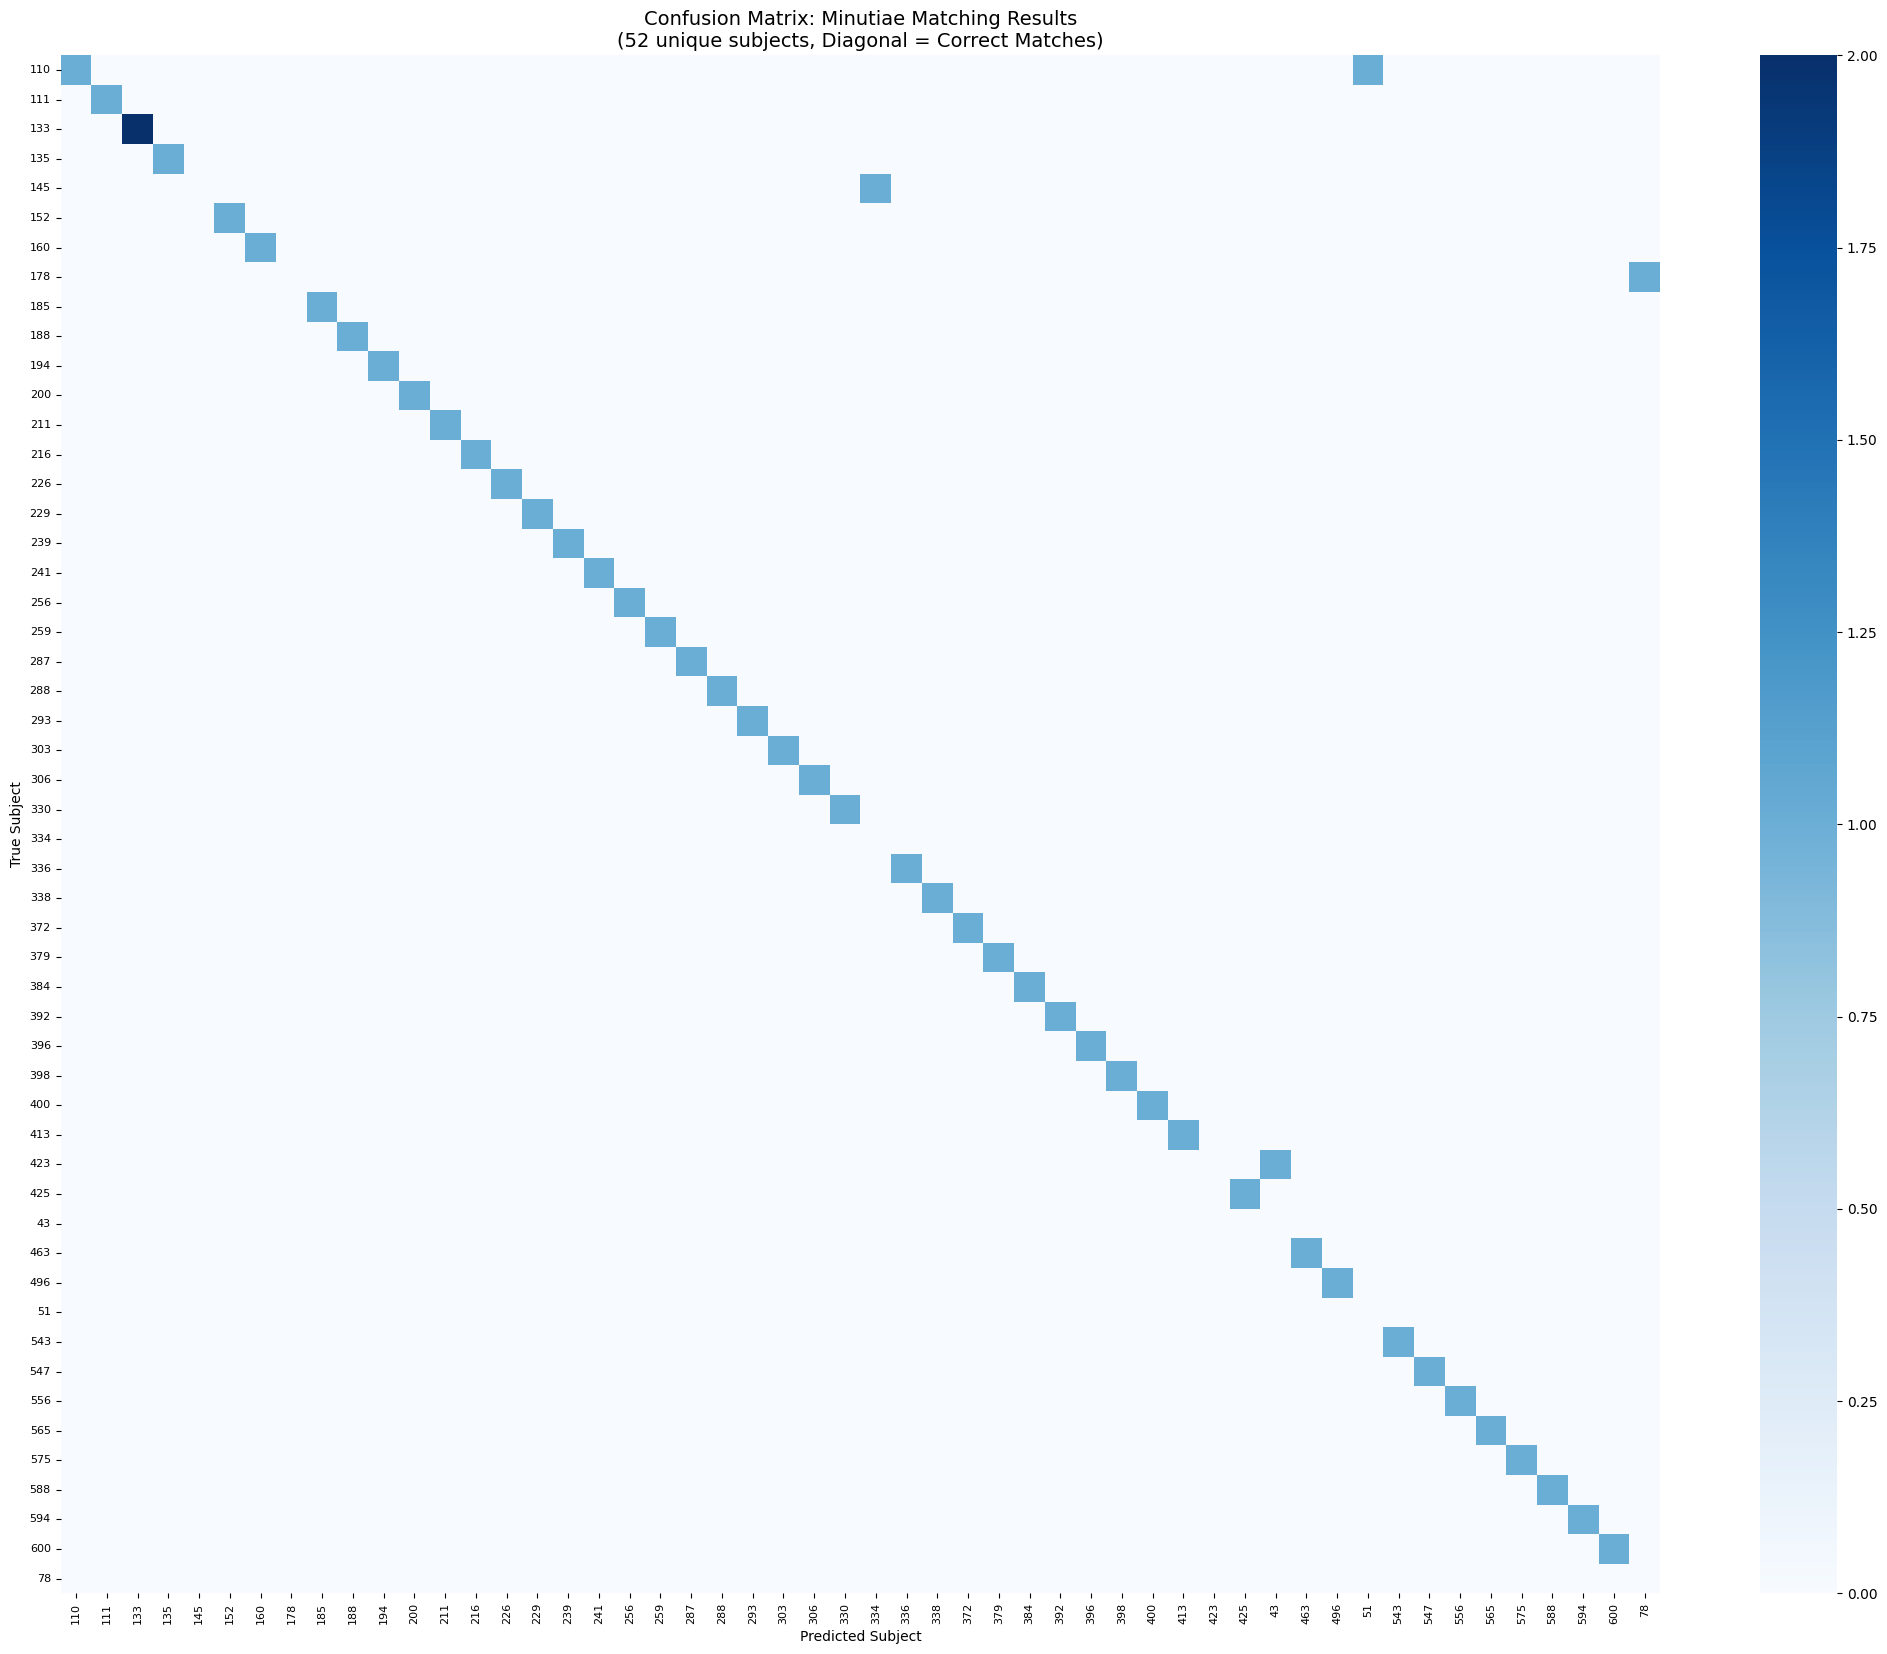


Confusion Matrix: 52 x 52
Diagonal (correct): 46
Off-diagonal (errors): 4
Accuracy: 92.00%


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

if len(valid_idx) > 0:
    subjects_gt = [parse_subject_finger(os.path.basename(p))[0] for p in gt_paths_valid]
    subjects_pred = [parse_subject_finger(os.path.basename(p))[0] for p in predicted_paths_valid]
    
    unique_subjects = sorted(list(set(subjects_gt + subjects_pred)))
    
    cm = confusion_matrix(subjects_gt, subjects_pred, labels=unique_subjects)
    
    # Use larger figure for many subjects
    fig_size = max(12, len(unique_subjects) * 0.4)
    plt.figure(figsize=(fig_size, fig_size * 0.8))
    
    # For many subjects, use smaller annotations
    annot = len(unique_subjects) <= 15
    
    sns.heatmap(cm, annot=annot, fmt='d', cmap='Blues',
              xticklabels=[f'{s}' for s in unique_subjects],
              yticklabels=[f'{s}' for s in unique_subjects])
    plt.title(f'Confusion Matrix: Minutiae Matching Results\n({len(unique_subjects)} unique subjects, Diagonal = Correct Matches)', fontsize=14)
    plt.xlabel('Predicted Subject')
    plt.ylabel('True Subject')
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics
    diagonal = sum(cm[i,i] for i in range(len(cm)))
    total = cm.sum()
    off_diagonal = total - diagonal
    
    print(f"\nConfusion Matrix: {cm.shape[0]} x {cm.shape[1]}")
    print(f"Diagonal (correct): {diagonal}")
    print(f"Off-diagonal (errors): {off_diagonal}")
    print(f"Accuracy: {diagonal / total * 100:.2f}%")

### Performance Comparison Table

Let's compare all three approaches side-by-side:

| Metric | Basic SIFT | SIFT + RANSAC | Minutiae k-NN |
|--------|------------|---------------|---------------|
| **Correct Match?** | WRONG (11.36%) | CORRECT (35.04%) | CORRECT (92%) |
| **Inliers/Consistency** | Unknown | 93% inliers | N/A |
| **Speed** | Fast | Fast | Slow (DB build) |
| **Implementation** | Simple | Moderate | Complex |

### Key Observations

- **Basic SIFT** alone is insufficient - it produces false matches.

- **RANSAC** adds geometric verification that fixes false matches.

- **Minutiae k-NN** achieves highest accuracy (92%) on altered fingerprints.

- Each approach builds on the previous one.

---

# Part 8: Interactive Exploration

The interactive test below uses **RANSAC-enhanced matching** (from Part 5). Try modifying parameters to see how they affect results.


In [ ]:
TEST_SUBJECT = "100"
TEST_FINGER = "Right_index_finger"
TEST_ALTERATION = "CR"
TEST_DIFFICULTY = "Hard"
TEST_LOW_RATIO = 0.75
TEST_RANSAC_THRESH = 5.0

query_path = DATA_ROOT / f"Altered/Altered-{TEST_DIFFICULTY}/{TEST_SUBJECT}__M_{TEST_FINGER}_{TEST_ALTERATION}.BMP"

print(f"=== Interactive Test (RANSAC-Enhanced) ===")
print(f"Query: {query_path.name}")
print(f"Lowe Ratio: {TEST_LOW_RATIO}")
print(f"RANSAC Threshold: {TEST_RANSAC_THRESH} pixels\n")

if not query_path.exists():
    print(f"File not found: {query_path.name}")
else:
    query_bgr = cv2.imread(str(query_path))
    query_gray = preprocess_gray(query_bgr)
    kp_q, des_q = sift.detectAndCompute(query_gray, None)
    
    print(f"Query keypoints: {len(kp_q)}")
    
    # Use ALL candidates (not just first 100)
    test_candidates = sorted([p for p in real_dir.iterdir() if p.suffix.lower() == '.bmp'])
    print(f"Searching through {len(test_candidates)} candidates...\n")
    
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    
    best_score = -1.0
    best_match = None
    best_inliers = 0
    
    for i, cand_path in enumerate(test_candidates):
        cand_bgr = cv2.imread(str(cand_path))
        if cand_bgr is None:
            continue
        
        cand_gray = preprocess_gray(cand_bgr)
        kp_c, des_c = sift.detectAndCompute(cand_gray, None)
        
        if des_c is None or len(kp_c) == 0:
            continue
        
        try:
            knn_matches = flann.knnMatch(des_q.astype(np.float32), des_c.astype(np.float32), k=2)
        except:
            continue
        
        # Lowe's ratio test
        good = [m for m, n in knn_matches if m.distance < TEST_LOW_RATIO * n.distance]
        
        # RANSAC verification
        num_inliers = 0
        if len(good) >= 4:
            src_pts = np.float32([kp_q[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_c[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, TEST_RANSAC_THRESH)
            if mask is not None:
                num_inliers = int(np.sum(mask))
        
        denom = min(len(kp_q), len(kp_c))
        score = (num_inliers / float(denom)) * 100.0 if denom > 0 else 0
        
        if score > best_score:
            best_score = score
            best_match = cand_path.name
            best_inliers = num_inliers
        
        if (i + 1) % 500 == 0:
            print(f"  Processed {i + 1}/{len(test_candidates)}... (Best: {best_score:.2f}%)")
    
    print(f"\nBest match: {best_match}")
    print(f"Score: {best_score:.2f}%")
    print(f"Inliers: {best_inliers}")
    
    expected = f"{TEST_SUBJECT}__M_{TEST_FINGER}.BMP"
    is_correct = best_match == expected if best_match else False
    status = "CORRECT" if is_correct else "WRONG"
    print(f"\nResult: {status}")
    if not is_correct and best_match:
        print(f"Expected: {expected}")

=== Interactive Test (RANSAC-Enhanced) ===
Query: 100__M_Right_index_finger_CR.BMP
Lowe Ratio: 0.75
RANSAC Threshold: 5.0 pixels

Query keypoints: 127
Searching through 6000 candidates...

  Processed 500/6000... (Best: 35.04%)
  Processed 1000/6000... (Best: 35.04%)
  Processed 1500/6000... (Best: 35.04%)
  Processed 2000/6000... (Best: 35.04%)
  Processed 2500/6000... (Best: 35.04%)
  Processed 3000/6000... (Best: 35.04%)
  Processed 3500/6000... (Best: 35.04%)
  Processed 4000/6000... (Best: 35.04%)
  Processed 4500/6000... (Best: 35.04%)
  Processed 5000/6000... (Best: 35.04%)
  Processed 5500/6000... (Best: 35.04%)
  Processed 6000/6000... (Best: 35.04%)

Best match: 100__M_Right_index_finger.BMP
Score: 35.04%
Inliers: 41

Result: CORRECT


---

# Part 9: Try Your Own.

## Experimentation Guide

### 1. Test Different Subjects
```python
TEST_SUBJECT = "200"
```

### 2. Test Different Fingers
```python
TEST_FINGER = "Left_thumb_finger"
```

### 3. Test Different Alteration Types
```python
TEST_ALTERATION = "Obl"
```

### 4. Test Different Difficulty Levels
```python
TEST_DIFFICULTY = "Easy"
```

### Learning Objectives Checklist

- [ ] Understand how SIFT extracts features
- [ ] See why RANSAC improves accuracy
- [ ] Compare traditional minutiae vs modern CV
- [ ] Identify failure cases
- [ ] Appreciate security implications

---

# Part 10: Summary and Key Takeaways

## What can we draw from this notebook

### 1. Dataset Structure

- SOCOFing contains 6,000 fingerprints from 600 subjects.

- Real fingerprints are unaltered; altered versions simulate damage/rotation.

- Three difficulty levels: Easy, Medium, Hard.


### 2. SIFT Feature Extraction

- Detects distinctive keypoints invariant to scale and rotation.

- Generates 128-dimensional descriptors.

- With RANSAC verification, successfully matches altered fingerprints.

### 3. Matching Process

- **FLANN**: Fast approximate nearest neighbor search.

- **Lowe's Ratio Test**: Filters ambiguous matches.

- **RANSAC**: Geometric verification for reliability.

### 4. Minutiae Analysis

- Traditional forensic approach using ridge endings/bifurcations.

- Skeletonization reduces ridges to 1-pixel width.

- k-NN classification achieving 92% accuracy.

## Cybersecurity Implications

### As an Adversary (Red Team)

- Understanding matching algorithms helps identify vulnerabilities.

- Altered fingerprints can sometimes bypass systems.

### As a Defender (Blue Team)

- Combine multiple techniques for robustness.

- Geometric verification (RANSAC) helps detect spoofing.

- Use working copies to protect original biometric data.

## References

- [SOCOFing Dataset](https://www.kaggle.com/datasets/ruizgara/socofing)
- [The paper presenting the Sokoto Coventry Fingerprint Dataset (SOCO-
Fing)](https://arxiv.org/pdf/1807.10609)
- [SIFT Paper](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)
- [OpenCV Documentation](https://docs.opencv.org/)

---

### **Important**: This notebook is for educational research only. Do not deploy these toy pipelines as an authentication mechanism. Fingerprint authentication requires liveness detection, carefully calibrated thresholds, and privacy/legal safeguards.


---

### Dataset & Ethics: SOCOFing is a public dataset used for research; check its license and ensure experiments respect ethical guidance for biometric data.

---

## Legal Compliance & Research Governance

This project, Digiti Signum, is conducted strictly for scientific research and educational purposes. To ensure alignment with European digital standards, the following frameworks apply:

1. EU AI Act Compliance

    - Research Exemption: This project falls under the Scientific Research Exception (Article 2(6)) of the EU AI Act. It is developed and used exclusively for R&D purposes and is not "placed on the market" or "put into service" for operational biometric identification.

    - Prohibited Practices Warranty: This repository does not implement or support prohibited AI practices, such as untargeted scraping of facial images, emotion recognition in workplaces, or social scoring.

    - Transparency: All results provided in the notebooks are for performance analysis between CV and Deep Learning and should not be used as a basis for real-world legal or forensic profiling.

2. GDPR & Data Privacy

    - Dataset Integrity: This project uses the SOCOFing dataset, which consists of synthetic/volunteer-provided data for research. No real-world, non-consensual personal data is processed or stored in this repository.

    - Data Minimization: Processing is limited to the features (minutiae/embeddings) necessary to demonstrate matching and alteration detection, in accordance with Article 89 of the GDPR (Safeguards for scientific research).

    - Local Processing: All computations are designed to be run locally; no biometric data is transmitted to third-party cloud services by the code provided here.